In [62]:
import pandas as pd
import glob, os
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
import string
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# [3월 21일]
---

## # 군집화
---

### # 데이터 전처리
---

In [21]:
path = r'D:\workspace\cakd5\m8_머신러닝 응용\data\OpinosisDataset1.0\topics'
all_files = glob.glob(os.path.join(path, "*.data"))

# 개별 파일들의 파일명은 filename_list로 취합
# 개별 파일들의 파일내용은 DataFrame 로딩 후 다시 string으로 변환하여 opinion_text 리스트로 취합
filename_list = []
opinion_text = []
for file_ in all_files:
    df = pd.read_table(file_, index_col = None, header = 0, encoding = 'latin1')
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename': filename_list, 'opinion_text': opinion_text})
document_df.head()

,filename,opinion_text
0,accuracy_garmin_nuvi_255W_gps,...
1,bathroom_bestwestern_hotel_sfo,...
2,battery-life_amazon_kindle,...
3,battery-life_ipod_nano_8gb,...
4,battery-life_netbook_1005ha,...


In [22]:
document_df['opinion_text'][0]

"                                                                                                                                                                                                                                                               , and is very, very accurate .\n0                                                                                                                                                                           but for the most part, we find that the Garmin software provides accurate directions, whereever we intend to go .\n1                                                                                                              This function is not accurate if you don't leave it in battery mode say, when you stop at the Cracker Barrell for lunch and to play one of those trangle games with the tees .\n2                                                                                                                                         

In [24]:
# 토큰화 사용자 함수

from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation) # punctuation 제거
lemma = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemma.lemmatize(token) for token in tokens]

def LemNormarlize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer = LemNormarlize, stop_words = 'english', ngram_range = (1, 2), min_df = 0.05, max_df = 0.85)
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

C:\Users\spiner\anaconda3\envs\cakd5\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


### # 군집화
---

In [89]:
from sklearn.cluster import KMeans

# 5개 집합으로 군집화

km_cluster = KMeans(n_clusters = 5, max_iter = 10000, random_state = 0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

document_df['cluster_label'] = cluster_label
display(document_df.head())
document_df.cluster_label.value_counts()

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,...,2
1,bathroom_bestwestern_hotel_sfo,...,0
2,battery-life_amazon_kindle,...,1
3,battery-life_ipod_nano_8gb,...,1
4,battery-life_netbook_1005ha,...,1


2    16
3    13
4    10
1     8
0     4
Name: cluster_label, dtype: int64

In [66]:
# cluster #0

document_df[document_df['cluster_label'] == 0].sort_values(by = 'filename')

,filename,opinion_text,cluster_label
1,bathroom_bestwestern_hotel_sfo,...,0
32,room_holiday_inn_london,...,0
30,rooms_bestwestern_hotel_sfo,...,0
31,rooms_swissotel_chicago,...,0


In [263]:
# 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성

def visualize_silhouette(cluster_lists, X_features, max_iter): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    n_cols = 4
    n_rows = int(np.ceil(len(cluster_lists)/4))
    
    fig = plt.figure(figsize = (25, 8*n_rows))
    plt.subplots_adjust(hspace = 0.35)
#     plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)  # 서브플롯 공간 띄우기
    for ind, n_cluster in enumerate(cluster_lists):
        clusterer = KMeans(n_clusters = n_cluster, max_iter = max_iter, random_state = 0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        ax = fig.add_subplot(n_rows, n_cols, ind+1)
        ax.set_title(f'\
            max_iter : {str(max_iter)} \n\n \
            Number of Cluster : {str(n_cluster)} \n \
            Silhouette Score : {str(round(sil_avg,3))}')
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, X_features.shape[0] + (n_cluster + 1) * 10])
        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx()형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        ax.axvline(x=sil_avg, color="red", linestyle="--")

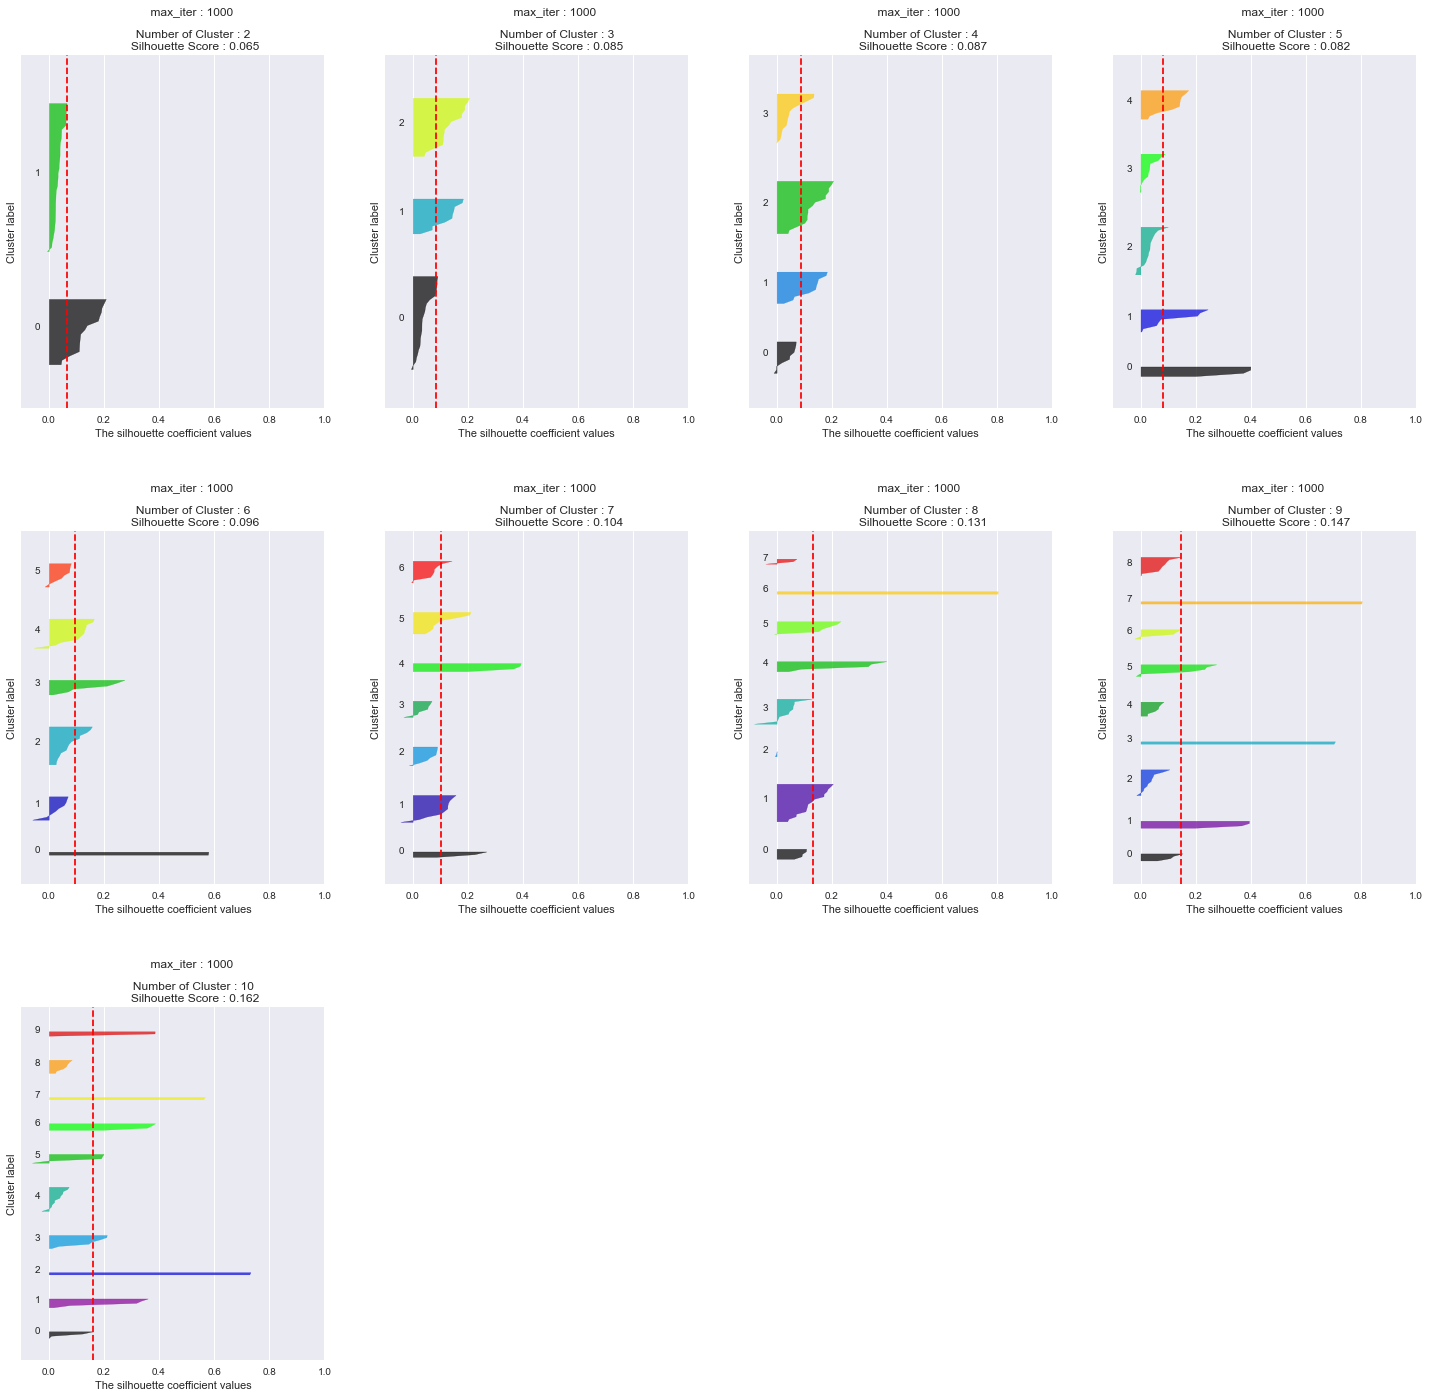

In [268]:
clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
max_iters = [1000]
for max_iter in max_iters:
    visualize_silhouette(clusters, feature_vect, max_iter)

### # 군집별 핵심 단어 추출
---